# Introduction

In this project, my aim is to compare the performance of two classifiers: one implemented using *PySpark* and the other using *Scikit-learn*. 

- Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees during training and outputting the mode of the classes for classification tasks. It is known for its high accuracy, robustness, and ability to handle large datasets.

- GradientBoostingClassifier builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions.

- The dataset used in this project is the *Mushroom Classification Dataset*, which includes several features related to various mushroom attributes, with the goal of predicting whether a mushroom is edible or poisonous. To ensure an unbiased comparison, both models were trained on the same training data, and their accuracy was evaluated using a test set.

- Despite the inherent differences in the underlying frameworks—*PySpark* being suited for big data processing and distributed computing, and *Scikit-learn* being a widely-used library for machine learning in Python—both models achieved the *same accuracy* on the test dataset. This outcome highlights the robustness of the Random Forest algorithm across different platforms, providing valuable insights into the versatility of machine learning models when applied to classification tasks.

- Through this analysis, I gained an understanding of how both libraries perform for this classification task, and I explored the importance of the features in making predictions. The results suggest that both PySpark and Scikit-learn Random Forest models are equally capable of handling this dataset, making them viable options depending on the use case—whether you're working with large datasets in a distributed environment or with smaller datasets where simplicity and ease of use are prioritized.

# Imports

In [47]:
import warnings
import pandas as pd
import seaborn as sn
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn.metrics import accuracy_score
from pyspark.sql.functions import count, col
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [36]:
warnings.filterwarnings('ignore')

# Initialize a spark session.

In [2]:
spark = SparkSession.builder.appName("MushroomClassification").getOrCreate()

In [3]:
# Load the dataset
df = spark.read.csv("./data/mushrooms.csv", header=True, inferSchema=True)

In [4]:
# Show the first 5 rows
df.show(5)

+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|class|cap-shape|cap-surface|cap-color|bruises|odor|gill-attachment|gill-spacing|gill-size|gill-color|stalk-shape|stalk-root|stalk-surface-above-ring|stalk-surface-below-ring|stalk-color-above-ring|stalk-color-below-ring|veil-type|veil-color|ring-number|ring-type|spore-print-color|population|habitat|
+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|    p|        x|          s|        n|      t|   p|              f|           c|        n|   

In [5]:
df.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

In [6]:
print(f'Total Rows: {df.count()}')

Total Rows: 8124


In [7]:
df.select([count(col(c)).alias(c) for c in df.columns]).show()

+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|class|cap-shape|cap-surface|cap-color|bruises|odor|gill-attachment|gill-spacing|gill-size|gill-color|stalk-shape|stalk-root|stalk-surface-above-ring|stalk-surface-below-ring|stalk-color-above-ring|stalk-color-below-ring|veil-type|veil-color|ring-number|ring-type|spore-print-color|population|habitat|
+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
| 8124|     8124|       8124|     8124|   8124|8124|           8124|        8124|     8124|   

In [8]:
# Read in DataFrame using Pandas for visualization.
pdf = pd.read_csv("./data/mushrooms.csv")

In [9]:
# Show top five rows and columns.
pdf.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [10]:
pdf.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [11]:
# Encode Categorical Variables Using Label Encoding
label_encoders = {}

for column in pdf.columns:
    le = LabelEncoder()
    pdf[column] = le.fit_transform(pdf[column])
    label_encoders[column] = le  # Store encoders if needed later

In [12]:
# Split Features and Target
X = pdf.drop("class", axis=1)  # Features
y = pdf["class"]  # Target (label)

## Exploratory Data Analysis.

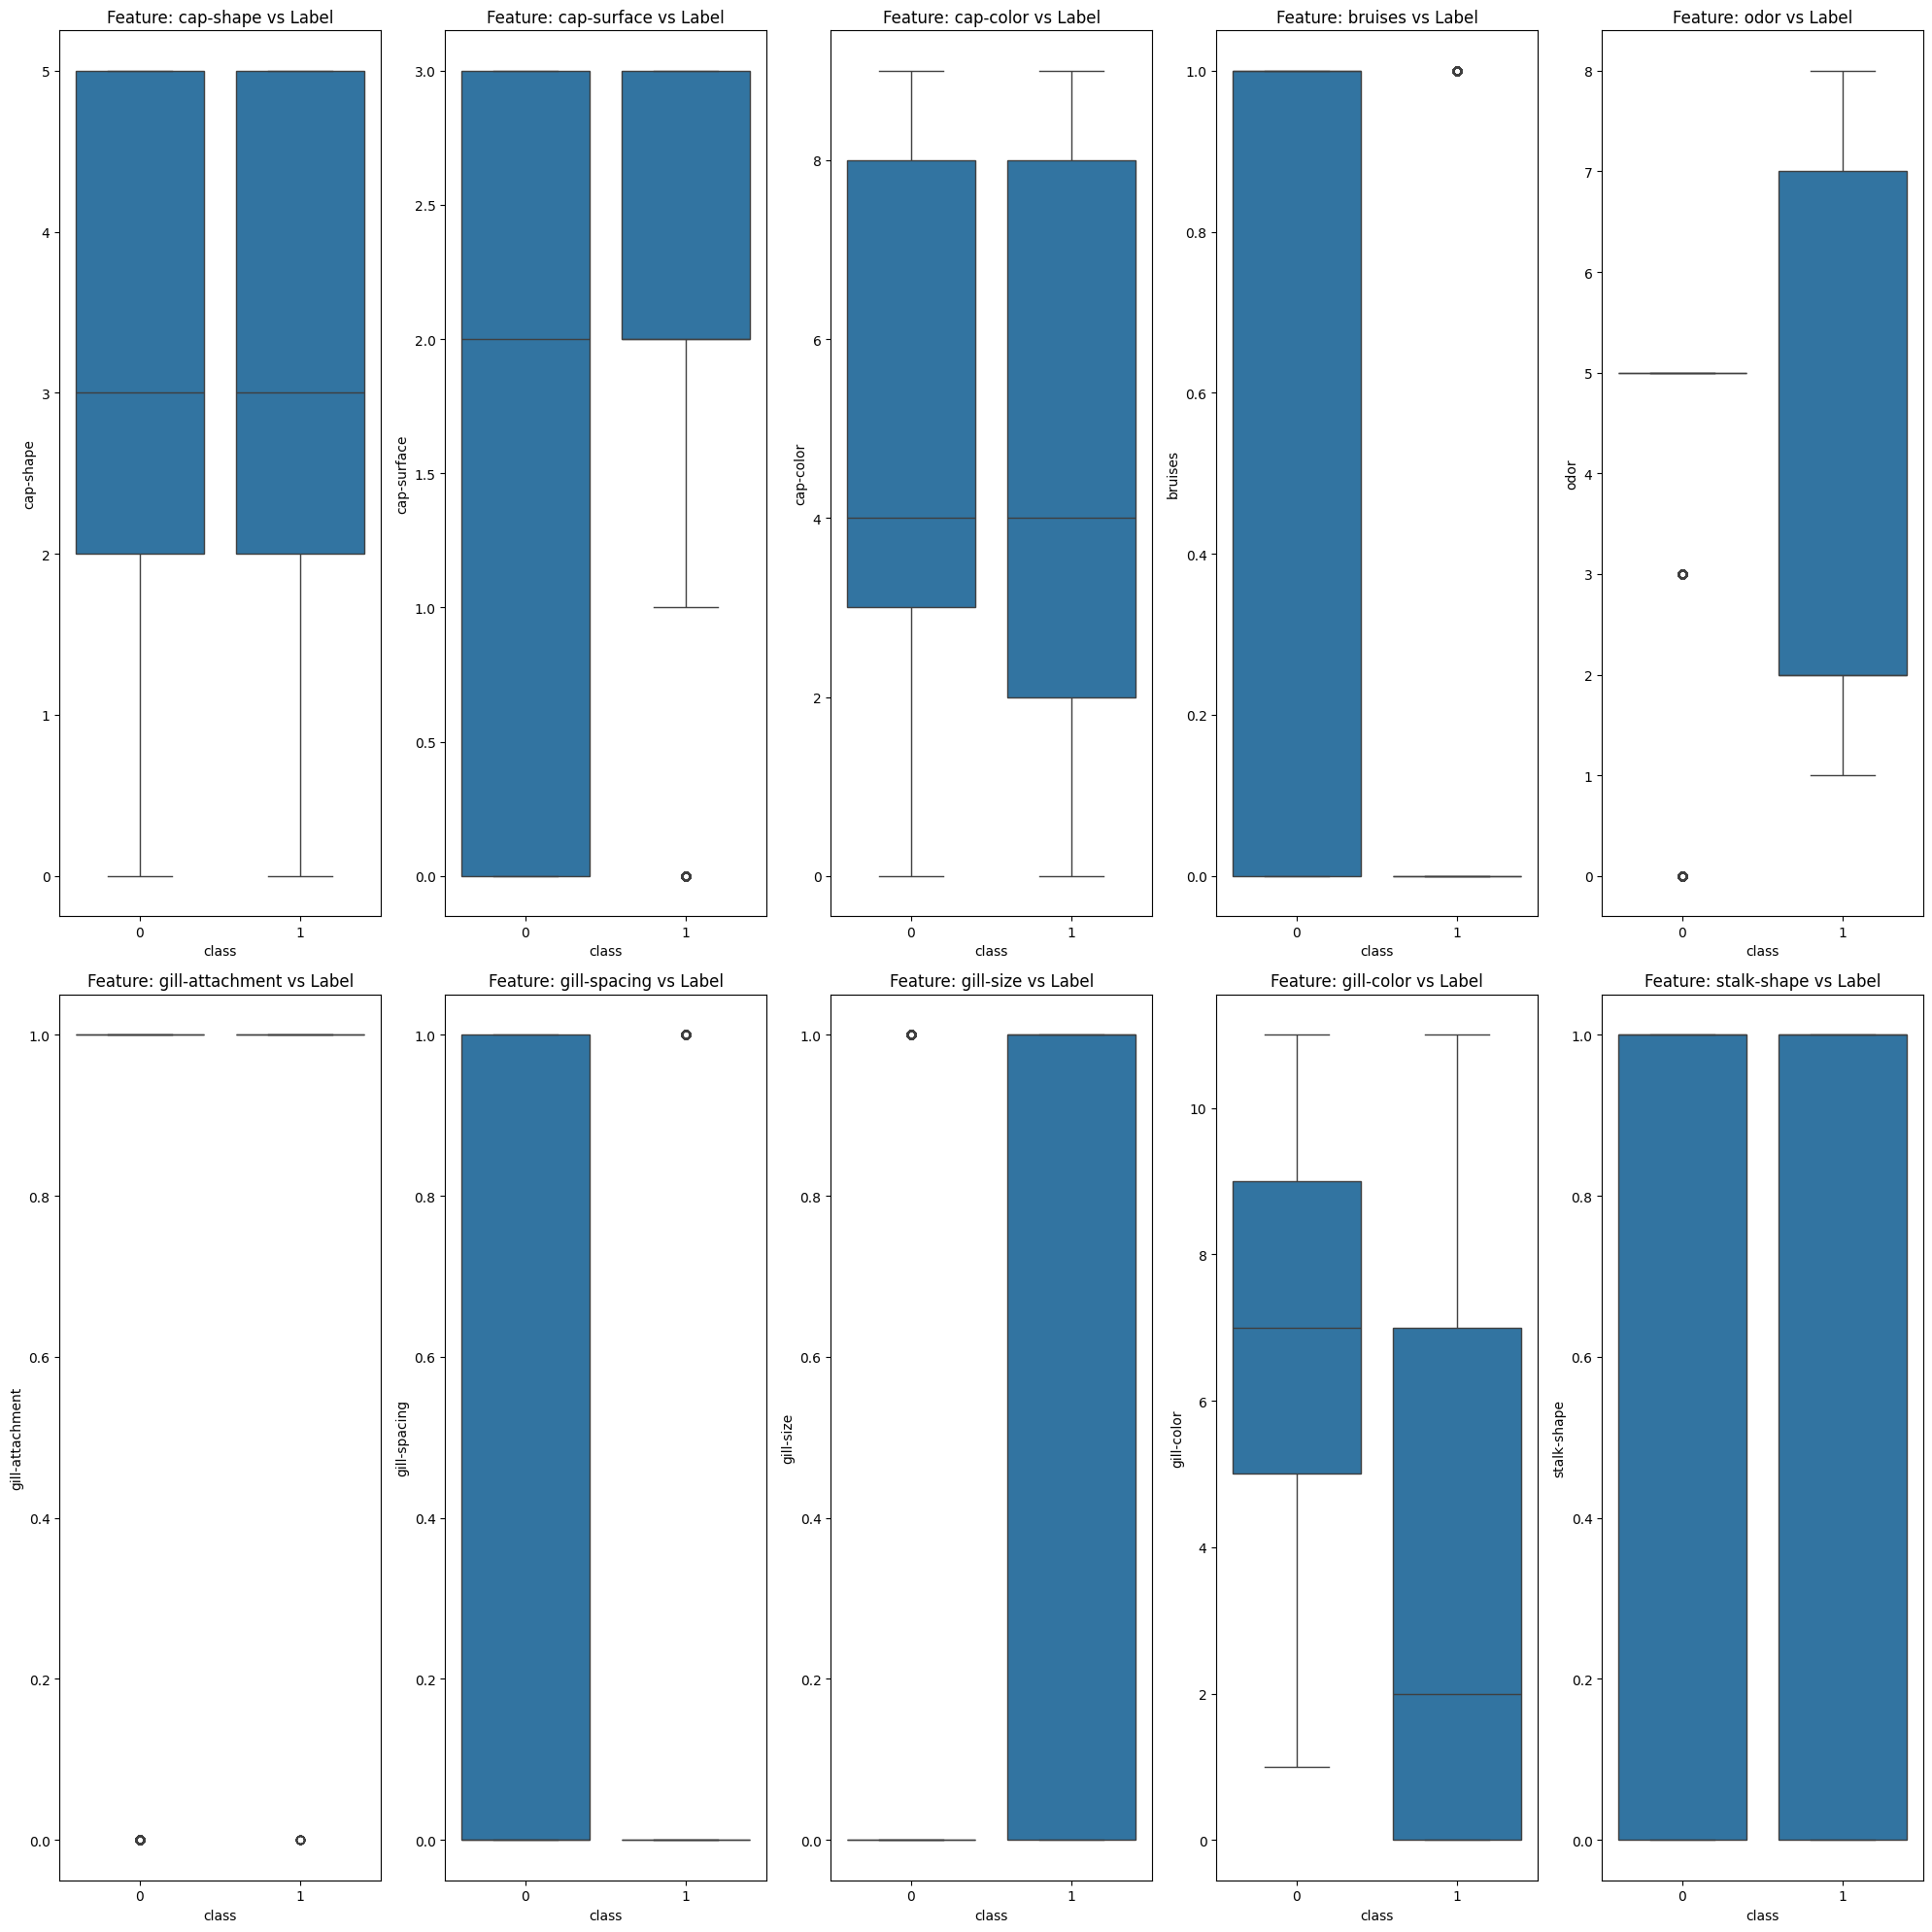

In [13]:
# Visualize Features Before Training
plt.figure(figsize=(20, 20))

for i, feature in enumerate(X.columns[:10]):  # Plot first 10 features
    plt.subplot(2, 5, i+1)
    sn.boxplot(x=y, y=X[feature])
    plt.title(f"Feature: {feature} vs Label")

plt.tight_layout()
plt.show()

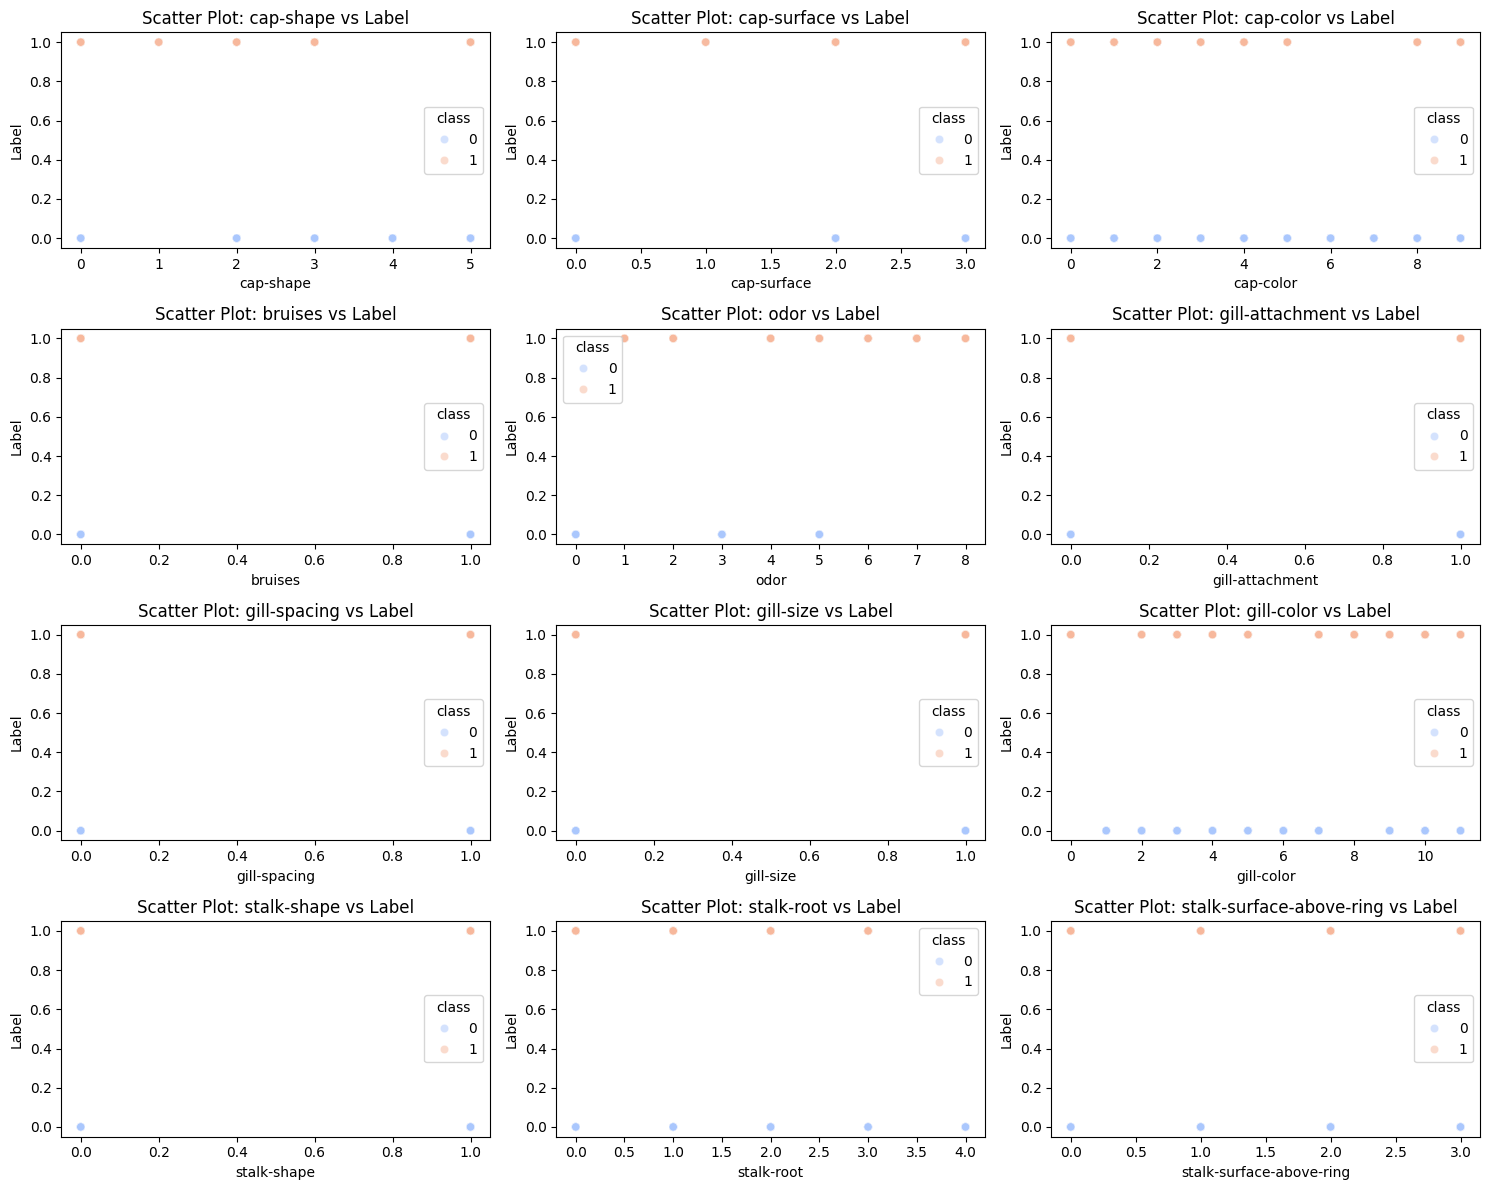

In [14]:
# Scatter plots of first 10 features vs label
plt.figure(figsize=(15, 12))

for i, feature in enumerate(X.columns[:12]):  # Plot first 12 features
    plt.subplot(4, 3, i+1)
    sn.scatterplot(x=X[feature], y=y, alpha=0.5, palette="coolwarm", hue=y)
    plt.xlabel(feature)
    plt.ylabel("Label")
    plt.title(f"Scatter Plot: {feature} vs Label")

plt.tight_layout()
plt.show()

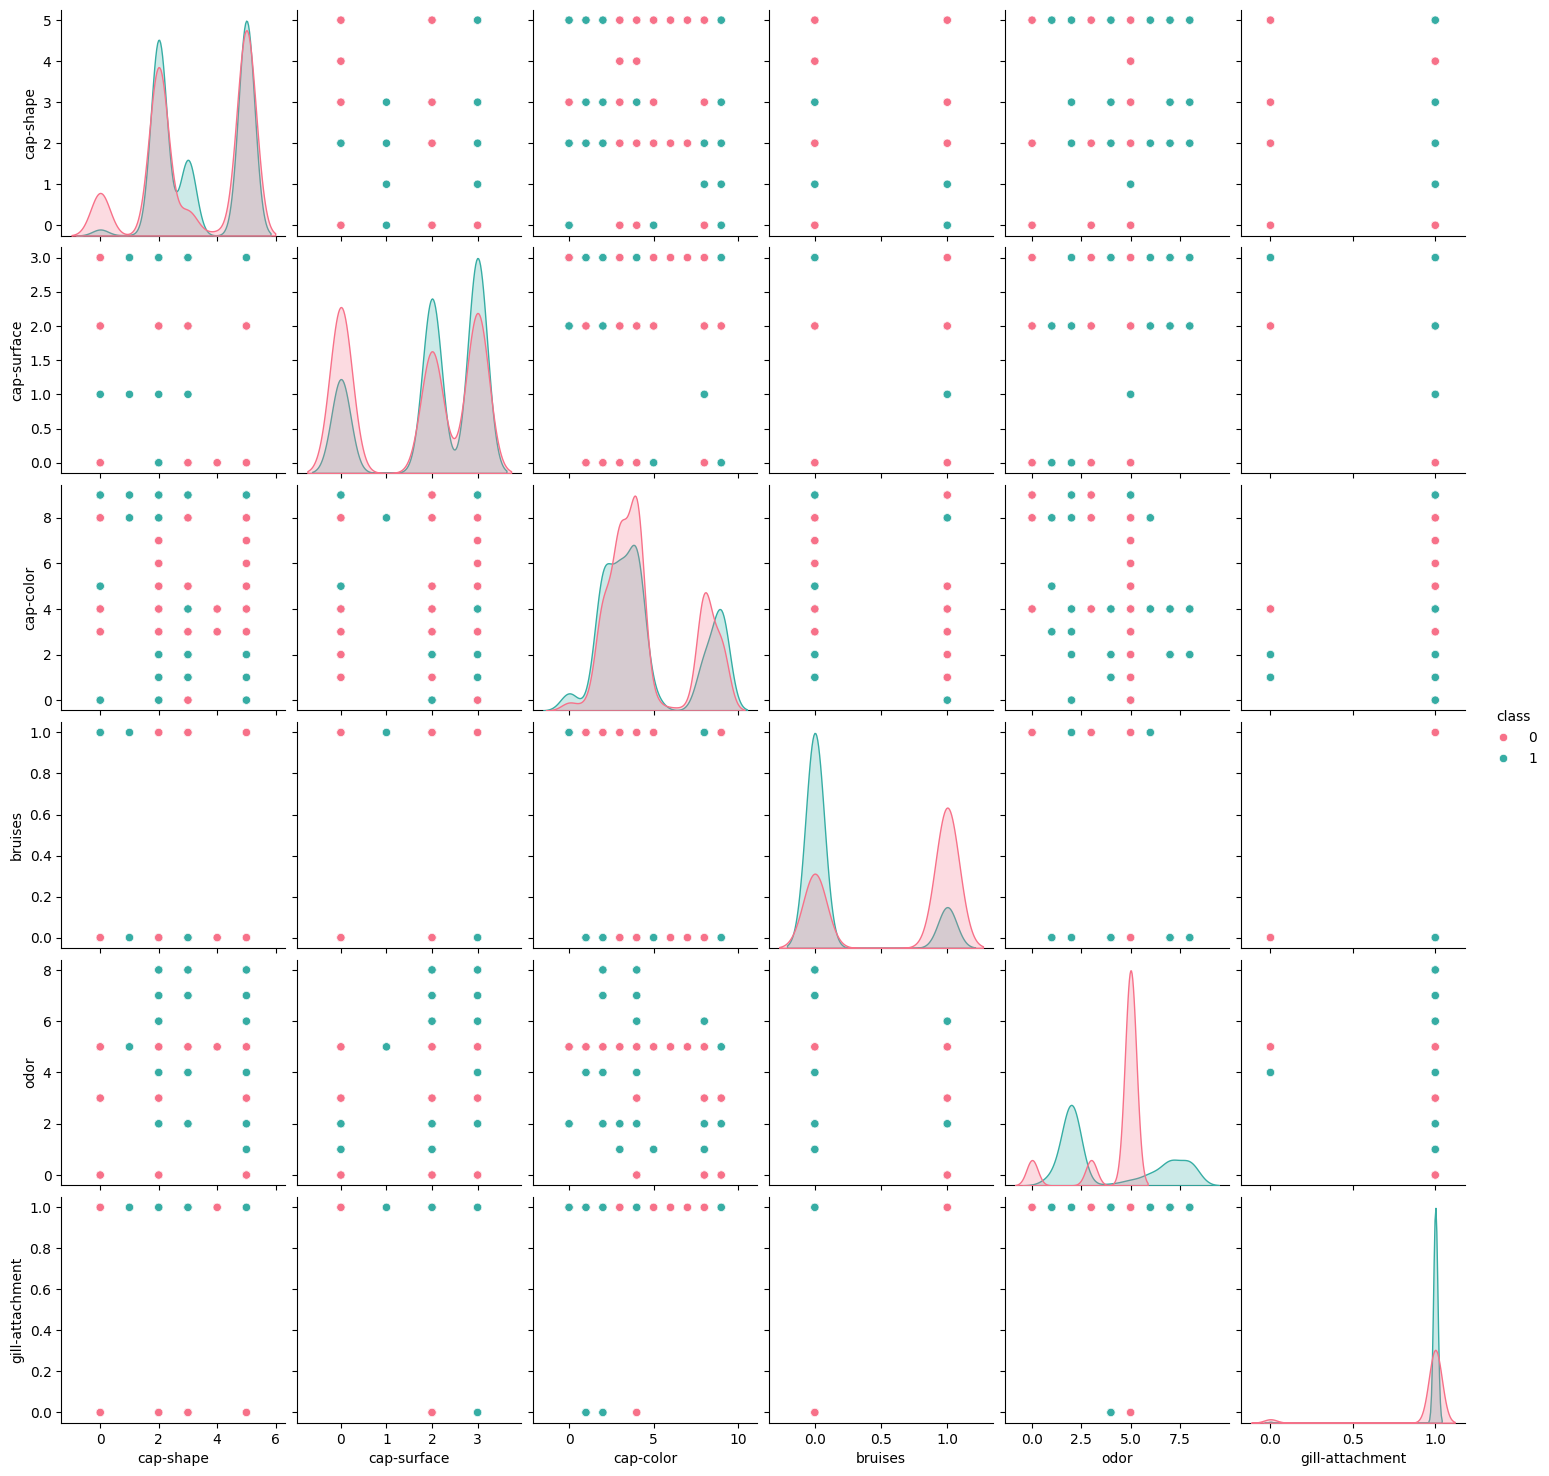

In [15]:
# Pairplot for Feature Relationships
sn.pairplot(pdf, hue="class", vars=X.columns[:6], palette="husl")
plt.show()

### Data Split in Sklearn.

In [16]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

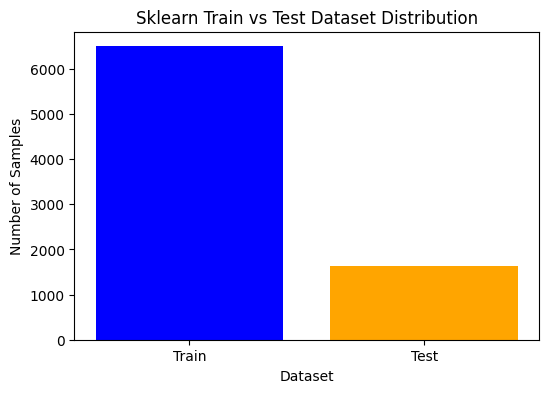

In [17]:
# Train/Test Dataset Distribution
plt.figure(figsize=(6, 4))

plt.bar(["Train", "Test"], [len(X_train), len(X_test)], color=['blue', 'orange'])
plt.xlabel("Dataset")
plt.ylabel("Number of Samples")
plt.title("Sklearn Train vs Test Dataset Distribution")

plt.show()

In [18]:
# Convert Categorical Features using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in df.columns if column != "class"]

# Apply transformations
for indexer in indexers:
    df = indexer.transform(df)

In [19]:
# Encode Target Variable
label_indexer = StringIndexer(inputCol="class", outputCol="label").fit(df)
df = label_indexer.transform(df)

In [20]:
df.show(5)

+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+---------------+-----------------+---------------+-------------+----------+---------------------+------------------+---------------+----------------+-----------------+----------------+------------------------------+------------------------------+----------------------------+----------------------------+---------------+----------------+-----------------+---------------+-----------------------+----------------+-------------+-----+
|class|cap-shape|cap-surface|cap-color|bruises|odor|gill-attachment|gill-spacing|gill-size|gill-color|stalk-shape|stalk-root|stalk-surface-above-ring|stalk-surface-below-ring|stalk-color-above-ring|stalk-color-below-ring|veil-type|veil-color|ring-number|ring-type|sp

In [21]:
# Select Indexed Features Only
indexed_cols = [col for col in df.columns if col.endswith("_index") or col=="label"]
df = df.select(indexed_cols)

In [22]:
df.show(8)

+---------------+-----------------+---------------+-------------+----------+---------------------+------------------+---------------+----------------+-----------------+----------------+------------------------------+------------------------------+----------------------------+----------------------------+---------------+----------------+-----------------+---------------+-----------------------+----------------+-------------+-----+
|cap-shape_index|cap-surface_index|cap-color_index|bruises_index|odor_index|gill-attachment_index|gill-spacing_index|gill-size_index|gill-color_index|stalk-shape_index|stalk-root_index|stalk-surface-above-ring_index|stalk-surface-below-ring_index|stalk-color-above-ring_index|stalk-color-below-ring_index|veil-type_index|veil-color_index|ring-number_index|ring-type_index|spore-print-color_index|population_index|habitat_index|label|
+---------------+-----------------+---------------+-------------+----------+---------------------+------------------+---------------

In [23]:
# Assemble Features
feature_cols = [col for col in df.columns if col != "label"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df = assembler.transform(df).select("features", "label")

In [24]:
df.show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(22,[1,3,4,7,8,9,...|  1.0|
|(22,[1,2,3,4,8,9,...|  0.0|
|(22,[0,1,2,3,4,8,...|  0.0|
|(22,[2,3,4,7,8,9,...|  1.0|
|(22,[1,2,6,8,10,1...|  0.0|
|(22,[2,3,4,8,9,10...|  0.0|
|(22,[0,1,2,3,4,8,...|  0.0|
|(22,[0,2,3,4,8,9,...|  0.0|
|(22,[2,3,4,7,8,9,...|  1.0|
|(22,[0,1,2,3,4,8,...|  0.0|
+--------------------+-----+
only showing top 10 rows



### Data split in Pyspark.

In [25]:
# Split Data into Training and Testing Sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

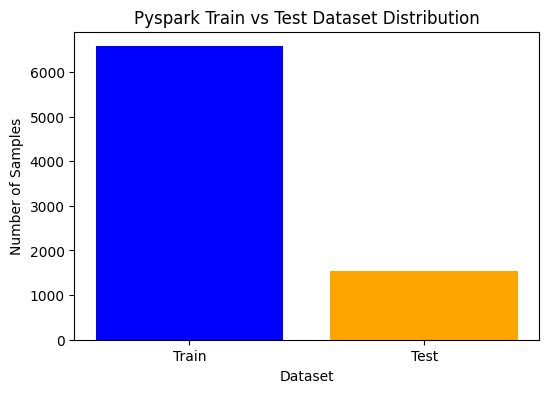

In [45]:
# Train/Test Dataset Distribution
train_count = train_df.count()
test_count = test_df.count()

plt.figure(figsize=(6, 4))
plt.bar(["Train", "Test"], [train_count, test_count], color=['blue', 'orange'])

plt.xlabel("Dataset")
plt.ylabel("Number of Samples")

plt.title("Pyspark Train vs Test Dataset Distribution")
plt.show()

# Model Creation.

In [54]:
skmodel = GradientBoostingClassifier()
skmodel.fit(X_train, y_train)

GradientBoostingClassifier()

In [55]:
# Train a Classification Model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)
model = rf.fit(train_df)

In [56]:
# Make Predictions
y_pred = skmodel.predict(X_test)

### Sklearn model evaluation.

In [57]:
# Evaluate Model Accuracy
sklearn_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {sklearn_accuracy * 100:.2f}%")

Test Accuracy: 100.00%


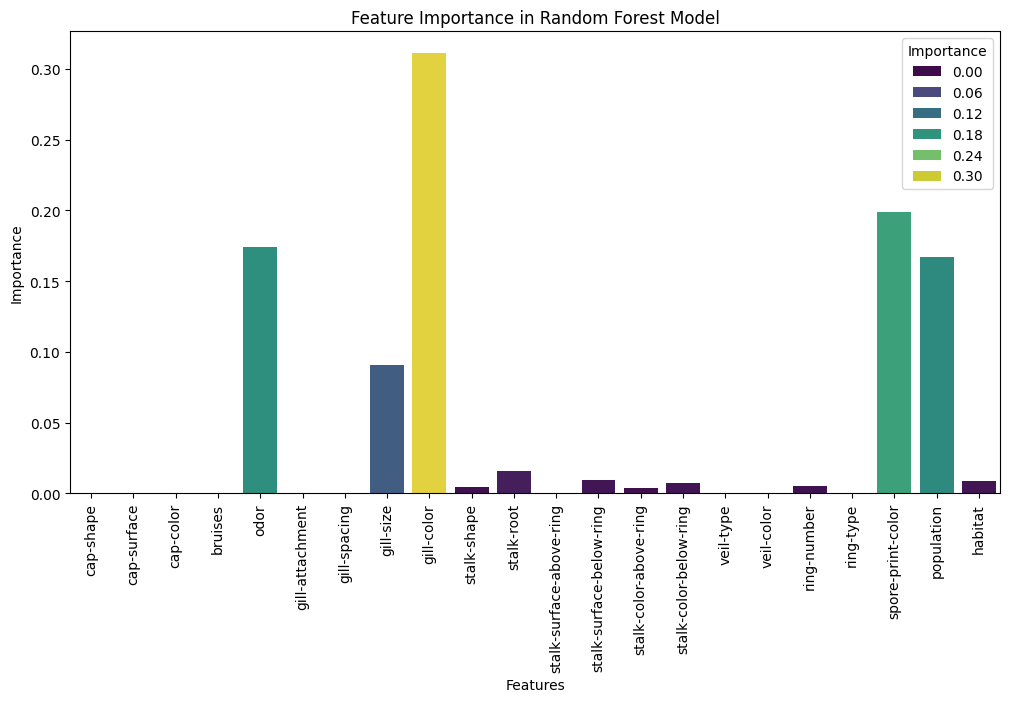

In [66]:
# Feature Importance Bar Plot with Hue
feature_importances = skmodel.feature_importances_

plt.figure(figsize=(12, 6))
sn.barplot(x=X.columns, y=feature_importances, hue=feature_importances, palette="viridis", dodge=False)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Model")

plt.legend(title="Importance", loc="upper right")
plt.show()

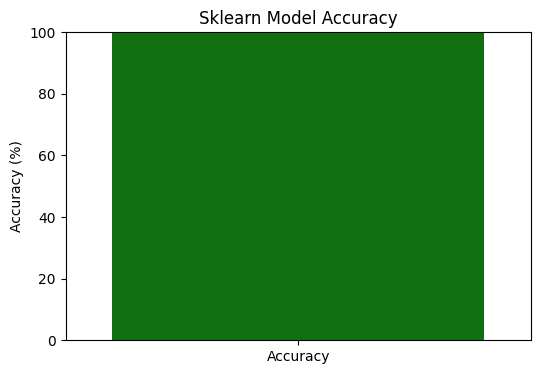

In [67]:
# Accuracy Visualization
plt.figure(figsize=(6, 4))
sn.barplot(x=["Accuracy"], y=[sklearn_accuracy * 100], color="green")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Sklearn Model Accuracy")

plt.show()

### Pyspark model evaluation.

In [68]:
# Make Predictions
predictions = model.transform(test_df)

In [69]:
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(22,[0,1,2,3,4,6,...|  0.0|[45.7118858557514...|[0.91423771711502...|       0.0|
|(22,[0,1,2,3,4,6,...|  0.0|[46.9017256328930...|[0.93803451265786...|       0.0|
|(22,[0,1,2,3,4,6,...|  0.0|[45.7118858557514...|[0.91423771711502...|       0.0|
|(22,[0,1,2,3,4,6,...|  0.0|[45.1454145281370...|[0.90290829056274...|       0.0|
|(22,[0,1,2,3,4,6,...|  0.0|[45.1454145281370...|[0.90290829056274...|       0.0|
|(22,[0,1,2,3,4,6,...|  0.0|[43.4555320270575...|[0.86911064054115...|       0.0|
|(22,[0,1,2,3,4,6,...|  0.0|[48.1102218900797...|[0.96220443780159...|       0.0|
|(22,[0,1,2,3,4,6,...|  0.0|[48.1102218900797...|[0.96220443780159...|       0.0|
|(22,[0,1,2,3,4,6,...|  0.0|[46.2376029717735...|[0.92475205943547...|       0.0|
|(22,[0,1,2,3,4,

In [70]:
# Evaluate Model Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
pyspark_accuracy = evaluator.evaluate(predictions)

In [71]:
pyspark_accuracy

1.0

In [72]:
print(f"Test Accuracy: {pyspark_accuracy * 100:.2f}%")

Test Accuracy: 100.00%


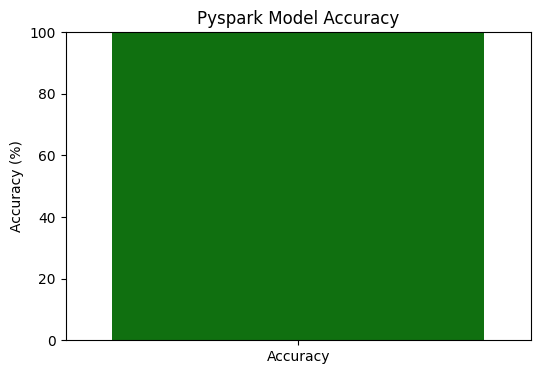

In [74]:
# Accuracy Visualization
plt.figure(figsize=(6, 4))
sn.barplot(x=["Accuracy"], y=[pyspark_accuracy * 100], color="green")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Pyspark Model Accuracy")

plt.show()

### Model accuracy comparison.

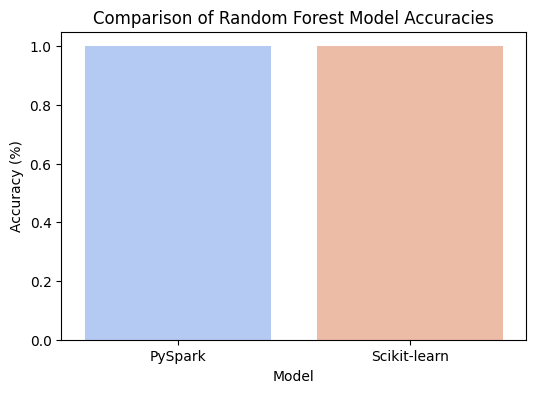

In [75]:
# Visualization for Comparison
accuracies = {
    "PySpark": pyspark_accuracy,
    "Scikit-learn": sklearn_accuracy
}

# Convert to DataFrame for better visualization handling
acc_df = pd.DataFrame(list(accuracies.items()), columns=["Model", "Accuracy"])

plt.figure(figsize=(6, 4))
sn.barplot(x="Model", y="Accuracy", data=acc_df, hue=acc_df["Model"], palette="coolwarm")  # Applying color palette
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Random Forest Model Accuracies")
plt.show()

# THE END !!!